<a href="https://colab.research.google.com/github/gaurangdave/mnist_object_detection/blob/main/notebooks/03_google_colab_migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Object Detection

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.datasets import fetch_openml
from keras.datasets import mnist


import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from matplotlib import patches



In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Access

## Set Constants  

In [ ]:
data_dir = Path("data")
models_dir = Path("models")

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Data Generation

In [ ]:
ALL_MNIST_DATA_PIXELS = x_train
ALL_MNIST_DATA_CLASSES = y_train

# number of digits to overlay on canvas
num_of_digits = 2

# max digits to define the shape of prediction output
MAX_DIGITS = 5


# Sample Base Digits
def get_sample_indices(dataset, size=5):
  random_indices = np.random.choice(len(dataset), size=size, replace=False)
  return random_indices

# helper function to sample number of digits from master dataset
def sample_base_digits(num_of_digits):
    """
    Sample a specified number of digit images and their class labels from the master MNIST dataset.

    Args:
        num_of_digits (int): Number of digit samples to retrieve.

    Returns:
        tuple: (sample_pixels, sample_values)
            sample_pixels (np.ndarray): Array of digit images with shape (num_of_digits, 28, 28, 1).
            sample_values (np.ndarray): Array of class labels with shape (num_of_digits, 1).
    """
    sample_indices = get_sample_indices(ALL_MNIST_DATA_PIXELS, size=num_of_digits)
    sample_pixels = ALL_MNIST_DATA_PIXELS[sample_indices]
    sample_pixels = sample_pixels.reshape(-1,28,28,1)

    sample_values = ALL_MNIST_DATA_CLASSES[sample_indices]
    sample_values = sample_values.reshape(-1, 1)

    # split the digits into pixels and class values
    # reshape the data to expected values
    # sample_pixels = sample.drop(
    #     columns=["class"]).to_numpy().reshape(-1, 28, 28, 1)
    # sample_values = sample["class"].values.reshape(-1, 1)
    return sample_pixels, sample_values
# Augment Digits


def plot_before_after(before_image, after_image):
    """
    Display two images side by side for visual comparison (e.g., before and after augmentation).

    Args:
        before_image (np.ndarray): The original image.
        after_image (np.ndarray): The image after transformation or augmentation.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs = axs.ravel()
    axs[0].imshow(before_image)
    axs[1].imshow(after_image)

    plt.axis("off")  # Remove axes for better visualization
    plt.show()
# helper function to apply random augmentation to digits


def augment_digits(digits, debug=False):
    """
    Apply random augmentations (translation, zoom, rotation) to a batch of digit images.

    Args:
        digits (np.ndarray): Array of digit images to augment.
        debug (bool, optional): If True, displays before/after images for each digit. Defaults to False.

    Returns:
        np.ndarray: Augmented digit images as a numpy array.
    """
    tensor_digits = tf.convert_to_tensor(digits)

    # step 2: apply random augmentation
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomTranslation(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomRotation(
            factor=0.1, fill_value=0.0, fill_mode="constant", seed=42),
    ])
    augmented_tensor_digits = augmentation(tensor_digits)

    # if debug is true render before digits
    if debug == True:
        for translated_imgs in range(tensor_digits.shape[0]):
            plot_before_after(
                tensor_digits[translated_imgs], augmented_tensor_digits[translated_imgs])

    # convert the tensor back to numpy to simplify use in map function
    return augmented_tensor_digits.numpy()
# Calculate Tight BBox
# helper function to calculate bounding box for each instance and return it.
# we are going to refactor the POC that we created ealier to use it with numpy arrays in the map function


def calculate_bounding_box(pixels, class_value, padding=1):
    """
    Calculate the tight bounding box for a digit image and return its coordinates and class value.

    Args:
        pixels (np.ndarray): 2D array representing the digit image.
        class_value (int): The class label of the digit.
        padding (int, optional): Padding to add around the bounding box. Defaults to 1.

    Returns:
        dict: Bounding box information including coordinates, center, width, height, and class value.
    """
    # calculate active rows & columns
    active_rows = np.sum(pixels, axis=1)
    active_columns = np.sum(pixels, axis=0)

    # calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    # add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)

    # calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)

    # calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height,
        "class_value": class_value
    }


# helper function to visualize the bounding box


def visualize_bounding_box(pixel_data, bounding_boxes, num_of_columns=5):
    """
    Visualize digit images with their corresponding bounding boxes.

    Args:
        pixel_data (np.ndarray): Array of digit images.
        bounding_boxes (list): List of bounding box dictionaries for each digit.
        num_of_columns (int, optional): Number of columns in the plot grid. Defaults to 5.
    """
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + \
        (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig, axs = plt.subplots(num_of_rows, num_of_columns, figsize=(10, 3))
    axs = axs.ravel()

    for idx in range(0, num_instances, 1):

        original = tf.constant(pixel_data[idx].reshape(28, 28, 1))
        converted = tf.image.grayscale_to_rgb(original)
        target_data = bounding_boxes[idx]
        x_center = target_data["x_center"]
        y_center = target_data["y_center"]
        width = target_data["width"]
        height = target_data["height"]

        x = target_data["x_min"]
        y = target_data["y_min"]

        rect = patches.Rectangle(
            (x, y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)

        axs[idx].set_title(target_data["class_value"])
        axs[idx].axis("off")
    plt.show()
# helper function to calculate bounding box for digits.


def calculate_tight_bbox(pixels, class_values, debug=False):
    """
    Calculate tight bounding boxes for a batch of digit images.

    Args:
        pixels (np.ndarray): Array of digit images.
        class_values (np.ndarray): Array of class labels for each digit.
        debug (bool, optional): If True, visualizes the bounding boxes. Defaults to False.

    Returns:
        list: List of bounding box dictionaries for each digit.
    """
    class_with_bbox = []
    for idx in range(pixels.shape[0]):
        class_with_bbox.append(calculate_bounding_box(
            pixels[idx], class_values[idx][0]))

    # if debug true render digits with bbox
    if debug == True:
        visualize_bounding_box(pixels, class_with_bbox, pixels.shape[0])

    return class_with_bbox
# Create Blank Canvas
# helper function to create  blank canvas


def create_blank_canvas(shape=(100, 100, 1)):
    """
    Create a blank canvas for placing digit images.

    Args:
        shape (tuple, optional): Shape of the canvas. Defaults to (100, 100, 1).

    Returns:
        np.ndarray: Blank canvas array.
    """
    canvas = np.zeros(shape=(100, 100, 1), dtype=np.float32)
    return canvas
# Create Prediction Object
# helper function to create empty predition structure based on MAX_DIGITS


def create_prediction_object():
    """
    Create an empty prediction object for storing digit detection results.

    Returns:
        np.ndarray: Prediction array of shape (MAX_DIGITS, 15).
    """
    prediction = np.zeros(shape=(MAX_DIGITS, 15), dtype=np.float32)
    return prediction
# Place Digit On Canvas


def is_valid_coordinates(top, left, class_bbox_value, existing_coordinates):
    """
    Check if the proposed top-left coordinates for a digit's bounding box are valid (within canvas and non-overlapping).

    Args:
        top (int): Proposed top coordinate.
        left (int): Proposed left coordinate.
        class_bbox_value (dict): Bounding box info for the digit.
        existing_coordinates (list): List of existing bounding boxes on the canvas.

    Returns:
        bool: True if coordinates are valid, False otherwise.
    """
    # # make sure the top and left are withing the canvas
    # if (top + 28 >= 100 or left + 28 >= 100):
    #     return False
    # read current class values
    # curr_x_center = class_bbox_value["x_center"]
    # curr_y_center = class_bbox_value["y_center"]
    curr_width = class_bbox_value["width"]
    curr_height = class_bbox_value["height"]
    curr_x_min = left
    curr_y_min = top
    curr_x_max = left + curr_width
    curr_y_max = top + curr_height

    # recalculate center with proposed top and left values
    # curr_x_center = curr_x_center + left
    # curr_y_center = curr_y_center + top

    # check 1: will the new bounding box go beyond the grid?
    if ((curr_x_min + curr_width) >= 100) or ((curr_y_min + curr_height) >= 100):
        return False

    # check 2: do bounding boxes overlap
    # check the current bounding box with every existing box
    for coord_idx in range(len(existing_coordinates)):
        existing_x_min = existing_coordinates[coord_idx]["x_min"]
        existing_y_min = existing_coordinates[coord_idx]["y_min"]
        existing_x_max = existing_coordinates[coord_idx]["x_max"]
        existing_y_max = existing_coordinates[coord_idx]["y_max"]
        if ((curr_x_min <= existing_x_max and curr_x_max >= existing_x_min) and (curr_y_min <= existing_y_max and curr_y_max >= existing_y_min)):
            return False

    return True


def select_top_left(class_bbox_value, existing_coordinates):
    """
    Randomly select valid top-left coordinates for placing a digit on the canvas.

    Args:
        class_bbox_value (dict): Bounding box info for the digit.
        existing_coordinates (list): List of existing bounding boxes on the canvas.

    Returns:
        tuple: (top, left) coordinates if valid, otherwise (-1, -1).
    """
    got_valid_coordinates = False
    # limiting the loop to run only 20 times
    retries = 0
    while ((not got_valid_coordinates) and (retries < 50)):
        top = np.random.randint(0, high=100)
        left = np.random.randint(0, high=100)
        got_valid_coordinates = is_valid_coordinates(
            top, left, class_bbox_value, existing_coordinates)
        retries = retries+1

    if got_valid_coordinates:
        return top, left
    return -1, -1


# helper function to render the canvas
# update the original plotting function to plot canvas as well.


def render_canvas(canvas, class_bbox):
    """
    Render the canvas with all placed digits and their bounding boxes.

    Args:
        canvas (np.ndarray): The canvas image.
        class_bbox (list): List of bounding box dictionaries for each digit.
    """
    num_of_digits = len(class_bbox)
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))
    axs.imshow(canvas)  # Use 'gray' colormap to render grayscale
    axs.axis("off")

    for idx in range(0, num_of_digits, 1):
        width = class_bbox[idx]["width"]
        height = class_bbox[idx]["height"]

        x = class_bbox[idx]["x_min"]
        y = class_bbox[idx]["y_min"]

        rect = patches.Rectangle(
            (x, y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')
        axs.add_patch(rect)

    plt.show()


def place_digit_on_canvas(canvas, pixels, class_bbox, debug=False):
    """
    Place digit images on the canvas at valid, non-overlapping locations.

    Args:
        canvas (np.ndarray): The blank canvas to place digits on.
        pixels (np.ndarray): Array of digit images.
        class_bbox (list): List of bounding box dictionaries for each digit.
        debug (bool, optional): If True, renders the canvas after placement. Defaults to False.

    Returns:
        tuple: (canvas, class_bbox) with updated canvas and bounding boxes.
    """
    # list to save all the valid existing coordinates
    existing_coordinates = []

    # in case if the algorithm cannot place a digit on canvas we'll drop that digit from pixel and class_bbox
    digits_to_drop = []

    total_digits = pixels.shape[0]
    # loop thru all the pixel values
    for idx in range(total_digits):
        class_bbox_value = class_bbox[idx]
        x_center = class_bbox_value["x_center"]
        y_center = class_bbox_value["y_center"]
        width = class_bbox_value["width"]
        height = class_bbox_value["height"]
        class_value = class_bbox_value["class_value"]
        x_min = class_bbox_value["x_min"]
        y_min = class_bbox_value["y_min"]
        x_max = class_bbox_value["x_max"]
        y_max = class_bbox_value["y_max"]

        # print(f"Width {width} & {int(width)}, Height {height} & {int(height)}")
        # width = int(width)
        # height = int(height)

        # step 1: find the right coordinates to place the digit
        top, left = select_top_left(class_bbox_value, existing_coordinates)
        if top != -1 and left != -1:
            # step 2: place the digit
            # canvas[y_min + top:y_min + top+height, x_min + left:x_min +
            #        left + width] = pixels[idx][y_min:y_min+height, x_min:x_min+width]

            canvas[top:top+height, left:
                   left + width] = pixels[idx][y_min:y_min+height, x_min:x_min+width]

            # step 3: recalculate the center based on top,left and update the class values with new center
            class_bbox_value["x_center"] = x_center + left
            class_bbox_value["x_min"] = left
            class_bbox_value["x_max"] = left + width

            class_bbox_value["y_center"] = y_center + top
            class_bbox_value["y_min"] = top
            class_bbox_value["y_max"] = top + height

            # update the array
            class_bbox[idx] = class_bbox_value
            # step 5: save the existing bounding box coordinates to help select the new one
            existing_coordinates.append(
                class_bbox_value
            )
        else:
            print(
                f"Error placing digit {class_value} on canvas. Couldn't fild valid coordinates")
            digits_to_drop.append(idx)

    # drop any bbox for which we couldn't find space in canvas
    filtered_bbox = [bbox for idx, bbox in enumerate(
        class_bbox) if idx not in digits_to_drop]

    if debug == True:
        render_canvas(canvas=canvas, class_bbox=filtered_bbox)

    return canvas, class_bbox
# Translate BBox To Prediction Object
# helper function to convert bbox diction to prediction object


def translate_bbox_to_prediction(current_bbox, prediction, debug=False):
    """
    Convert bounding box dictionaries to a prediction object suitable for training.

    Args:
        current_bbox (list): List of bounding box dictionaries.
        prediction (np.ndarray): Prediction array to update.
        debug (bool, optional): If True, prints mapping details. Defaults to False.

    Returns:
        np.ndarray: Updated prediction array.
    """
    # Sanity check - ideally prediction shape should be larger than or equal to number of elements in bbox
    if (prediction.shape[0] < len(current_bbox)):
        print(f"Error shape mismatch between prediction and bbox")
        return prediction

    for idx, bbox in enumerate(current_bbox):
        # set the flag indicating the digit is present
        prediction[idx][0] = 1
        # set x_center
        prediction[idx][1] = bbox["x_center"]
        # set y_center
        prediction[idx][2] = bbox["y_center"]
        # set width
        prediction[idx][3] = bbox["width"]
        # set height
        prediction[idx][4] = bbox["height"]
        # set one hot encoded value of the class
        # read the class value
        class_value = int(bbox["class_value"])
        # set the cell corresponding to class value to 1
        prediction[idx][5 + class_value] = 1
        if debug == True:
            print(f"current bbox is {bbox}")
            print(f"mapped prediction is {prediction[idx]}")

    return prediction
# Generate Training Example
# helper map function to map 28x28x1 image and its class to 100x100x1 canvas and prediction object


def generate_training_example(x, y, debug=False):
    """
    Generate a training example by placing digits on a canvas and creating the corresponding prediction object.

    Args:
        x (np.ndarray): Input digit image(s).
        y (np.ndarray): Corresponding class label(s).

    Returns:
        tuple: (canvas, prediction) where canvas is the composed image and prediction is the label array.
    """
    pixels = x.reshape(-1, 28, 28, 1)
    class_values = y.reshape(-1, 1)
    # step 1: sample additional digits
    if num_of_digits - 1 > 0:
        sample_pixels, sample_values = sample_base_digits(num_of_digits - 1)
        pixels = np.concatenate((pixels, sample_pixels))
        class_values = np.concatenate((class_values, sample_values), axis=0)

    # step 2: augment digits
    pixels = augment_digits(pixels, debug=debug)

    # step 3: calculate bounding box
    class_with_bbox = calculate_tight_bbox(pixels, class_values, debug=debug)

    # step 4: create blank canvas and prediction
    canvas = create_blank_canvas()
    prediction = create_prediction_object()

    # step 5: place digit on canvas
    canvas, class_bbox = place_digit_on_canvas(
        canvas, pixels, class_with_bbox, debug=debug)

    # step 6: translate bbox to prediction object
    prediction = translate_bbox_to_prediction(
        class_bbox, prediction, debug=debug)

    # print(f"Final canvas shape {canvas.shape}, final prediction shape {prediction.shape}")
    return (canvas, prediction)


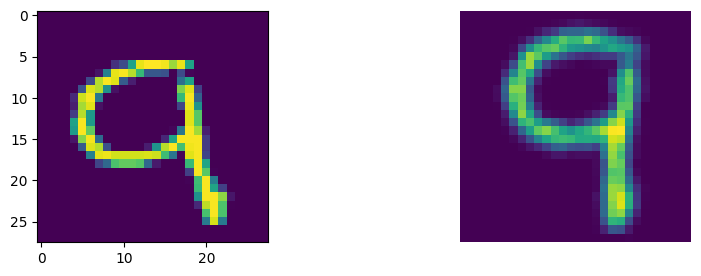

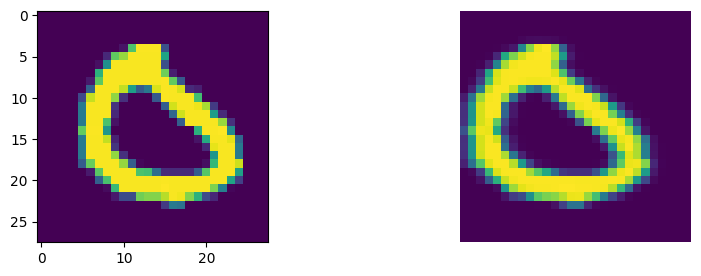

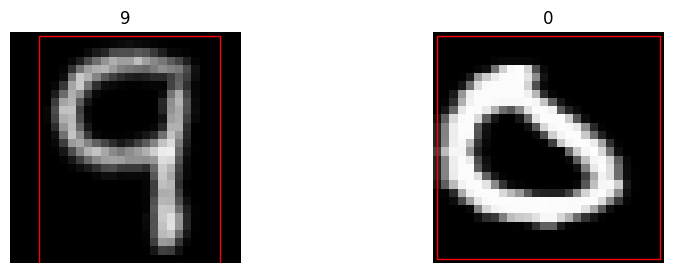

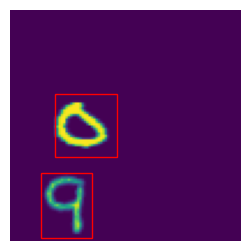

current bbox is {'x_min': 13, 'x_max': np.int64(35), 'y_min': 70, 'y_max': np.int64(98), 'x_center': 27, 'y_center': 84, 'width': np.int64(22), 'height': np.int64(28), 'class_value': np.uint8(9)}
mapped prediction is [ 1. 27. 84. 22. 28.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
current bbox is {'x_min': 19, 'x_max': np.int64(46), 'y_min': 36, 'y_max': np.int64(63), 'x_center': 32, 'y_center': 49, 'width': np.int64(27), 'height': np.int64(27), 'class_value': np.uint8(0)}
mapped prediction is [ 1. 32. 49. 27. 27.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [ ]:
sample_indices = get_sample_indices(x_train, 1)
test_x = x_train[sample_indices]
test_y = y_train[sample_indices]
canvas, prediction = generate_training_example(test_x,test_y,debug=True)

# Training & Evaluation

## Training Utils

In [ ]:
import tensorflow as tf

# helper function to convert box values to corner coordinates


def convert_boxes_to_corners(box_center_format):
    # we'll use the following formulas
    # x_min = floor(x_center - (width/2))
    # x_max = floor(x_center + (width/2))
    # y_min = floor(y_center - (height/2))
    # y_max = floor(y_cetner + (height /2))
    # calculate true values.
    x_min = tf.floor(
        box_center_format[:, :, :, 0] - (box_center_format[:, :, :, 2])/2)
    x_max = tf.floor(
        box_center_format[:, :, :, 0] + (box_center_format[:, :, :, 2])/2)
    y_min = tf.floor(
        box_center_format[:, :, :, 1] - (box_center_format[:, :, :, 3])/2)
    y_max = tf.floor(
        box_center_format[:, :, :, 1] + (box_center_format[:, :, :, 3])/2)

    coordinates = tf.stack(values=[x_min, y_min, x_max, y_max], axis=3)
    return coordinates

# helper function to find the intersection box corners from given 2 boxes


def calculate_intersection_corners(box_1_corners, box_2_corners):
    x_min_for_intersection = tf.maximum(
        box_1_corners[:, :, :, 0], box_2_corners[:, :, :, 0])
    y_min_for_intersection = tf.maximum(
        box_1_corners[:, :, :, 1], box_2_corners[:, :, :, 1])
    x_max_for_intersection = tf.minimum(
        box_1_corners[:, :, :, 2], box_2_corners[:, :, :, 2])
    y_max_for_intersection = tf.minimum(
        box_1_corners[:, :, :, 3], box_2_corners[:, :, :, 3])
    intersection_box_corners = tf.stack(
        values=[x_min_for_intersection, y_min_for_intersection, x_max_for_intersection, y_max_for_intersection], axis=3)
    return intersection_box_corners

# helper function to calculate the area of intersection between two boxes


def calculate_intersection_area(intersection_box_corners):
    # find the width = x_max - x_min, if the boxes are not intersecting, this value could be negative or 0
    intersection_width = tf.maximum(
        0.0, intersection_box_corners[:, :, :, 2] - intersection_box_corners[:, :, :, 0])
    # find the height = y_max - y_min, if the boxes are not intersecting, this value could be negative or 0
    intersection_height = tf.maximum(
        0.0, intersection_box_corners[:, :, :, 3] - intersection_box_corners[:, :, :, 1])
    # intersection area = width * height
    intersection_area = intersection_width * intersection_height
    return intersection_area

# helper function to calcualte the area of union between two boxes


def calculate_union_area(box_1_dimensions, box_2_dimensions, intersection_area):
    box_1_area = box_1_dimensions[:, :, :, 0] * box_1_dimensions[:, :, :, 1]
    box_2_area = box_2_dimensions[:, :, :, 0] * box_2_dimensions[:, :, :, 1]
    union_area = box_1_area + box_2_area - intersection_area
    return union_area

# helper function to calculate the IOU ration between boxes


def calculate_iou(intersection_area, union_area):
    iou = intersection_area / (union_area + 1e-8)
    return iou

# helper function to calculate indices for the grid cells that contain the object


def calculate_grid_cell_indices(y_true, y_pred):
    x_grid_size = tf.shape(y_pred)[1]


    # Read the bounding box centers
    # Each instance in the bach will have 5 bounding box centers
    # select boxes with objectness equal to 1
    # objectness_mask = y_true[:, :, 0] == 1.0
    # bounding_boxes_with_objects = tf.boolean_mask(y_true, mask=objectness_mask)
    # print(f"bounding_boxes_with_objects.shape : {bounding_boxes_with_objects.shape}")
    bounding_box_centers = y_true[:, :, 1:3]

    # TODO:  here we are assuming number of rows and columns in grid is same. Confirm the assumption.
    # The general formula is: grid_index = floor(pixel_coordinate * (grid_size / image_size))
    # convert each 5 bounding box centers to 5 possible grids for each instance

    grid_indices = tf.cast(
        tf.floor(bounding_box_centers * tf.cast((x_grid_size / 100),tf.float32)), dtype=tf.int32)

    ## grid_indices can be out of bounds if the box centers lie on coordinates that are in multiple of 100
    ## so we need to clip them to be maximum of 5 and minimum of 0
    grid_indices = tf.clip_by_value(grid_indices, clip_value_min=0, clip_value_max=x_grid_size - 1)

    # grid_indices = tf.reshape(grid_indices,shape=(batch_size,-1,2))
    # print(f"grid indices shape {tf.shape(grid_indices)}")
    # print(f"grid indices {grid_indices}")


    return grid_indices

# Helper function to calculate anchor box indices.


def calculate_anchorbox_indices(y_true, y_pred, grid_cell_indices):
    x_grid_size = y_pred.shape[1]
    y_grid_size = y_pred.shape[2]

    anchor_boxes = tf.reshape(
        y_pred, shape=(-1, x_grid_size, y_grid_size, 3, 15))
    # print(f"anchor_boxes.shape {anchor_boxes.shape}")

    selected_anchor_boxes = tf.gather_nd(
        anchor_boxes, batch_dims=1, indices=grid_cell_indices)
    # print(f"selected_anchor_boxes.shape :{selected_anchor_boxes.shape}")

    # calcualte the IOU between anchor boxes and ground truth
    expanded_y_true = tf.expand_dims(y_true, axis=2)

    # calculate min and max values for ground truth and anchor boxes
    y_true_box_corners = convert_boxes_to_corners(
        expanded_y_true[:, :, :, 1:5])
    y_pred_box_corners = convert_boxes_to_corners(
        selected_anchor_boxes[:, :, :, 1:5])
    # print(f"y_true_boxes.shape {y_true_box_corners.shape}")
    # print(f"y_pred_boxes.shape {y_pred_box_corners.shape}")

    # calculate the intersection coordinates between ground truth and anchor boxes
    intersection_box_corners = calculate_intersection_corners(
        y_true_box_corners[:, :, :, 0:], y_pred_box_corners[:, :, :, 0:])
    # print(f"intersection_box_corners.shape {intersection_box_corners.shape}")

    # calculate the IOU
    # calculate intersection area
    intersection_area = calculate_intersection_area(intersection_box_corners)
    # print(f"intersection_area.shape {intersection_area.shape}")

    # calculate union area
    # we just need the width and length for union area
    union_area = calculate_union_area(
        expanded_y_true[:, :, :, 3:5], selected_anchor_boxes[:, :, :, 3:5], intersection_area)
    # print(f"union_area.shape {union_area.shape}")

    # calculate IOU
    iou = calculate_iou(intersection_area, union_area)
    # print(f"iou.shape {iou.shape}")

    # select the anchor box based on best iou score
    # select the index with highest iou
    highest_iou_index = tf.argmax(iou, axis=2, output_type=tf.int32)
    # print(f"highest_iou_index.shape {highest_iou_index.shape}")

    highest_iou_index = tf.expand_dims(highest_iou_index, axis=2)
    # highest_iou_index = tf.reshape(highest_iou_index, shape=(iou.shape[0],iou.shape[1],-1))
    # print(f"expanded highest_iou_index.shape {highest_iou_index.shape}")
    return highest_iou_index



def calculate_best_anchor_boxes(y_true, y_pred):
    # helper function to calculate best anchor boxes
    x_grid_size = tf.shape(y_pred)[1]
    y_grid_size = tf.shape(y_pred)[2]
    batch_size = tf.shape(y_pred)[0]

    # print("----- True Values -----")
    # print(f"y_true.shape {tf.shape(y_true)}")

    # print("----- Pred Values -----")
    # print(f"y_pred.shape {tf.shape(y_pred)}")

    # we have 6x6, each grid cell has 3 anchor box i.e 108 anchor boxes per insantance
    anchor_boxes = tf.reshape(
        y_pred, shape=(batch_size, x_grid_size, y_grid_size, 3, 15))
    # print(f"anchor_boxes.shape {tf.shape(anchor_boxes)}")

    grid_cell_indices = calculate_grid_cell_indices(
        y_true=y_true, y_pred=y_pred)

    # out of 36 grid cells (per instance) select at most 5 grid cells that have ground truth bounding box
    # so out of 108 anchor boxes (per instance) we only need to check 15 anchor boxes
    selected_anchor_boxes = tf.gather_nd(
        params=anchor_boxes, batch_dims=1, indices=grid_cell_indices)
    # print(f"selected_anchor_boxes.shape :{selected_anchor_boxes.shape}")

    highest_iou_index = calculate_anchorbox_indices(
        y_true=y_true, y_pred=y_pred, grid_cell_indices=grid_cell_indices)
    # select the anchor box based on the index
    best_anchor_boxes = tf.gather(
        selected_anchor_boxes, indices=highest_iou_index, batch_dims=2)
    # print(f"best_anchor_boxes.shape {best_anchor_boxes.shape}")

    return best_anchor_boxes

# helper function to split and calculate loss


def calculate_loss(predicted_values, true_values):

    objectness_mask = true_values[:, :, :, 0] == 1.0

    true_values_with_objects = tf.boolean_mask(
        true_values, mask=objectness_mask)
    predicted_values_with_objects = tf.boolean_mask(
        predicted_values, mask=objectness_mask)

    # print(f"true_values_with_objects.shape : {true_values_with_objects.shape}")
    # print(
    #     f"predicted_values_with_objects.shape : {predicted_values_with_objects.shape}")
    # slice the 3 properties that we are tyring to calculate loss against
    # predicted values

    y_pred_objectness = predicted_values_with_objects[:, 0]
    # print(f"y_pred_objectness.shape : {y_pred_objectness.shape}")

    y_pred_bounding_box = predicted_values_with_objects[:, 1:5]
    # print(f"y_pred_bounding_box.shape : {y_pred_bounding_box.shape}")

    y_pred_classification = predicted_values_with_objects[:, 5:]
    # print(f"y_pred_classification.shape : {y_pred_classification.shape}")

    # True Values
    y_true_objectness = true_values_with_objects[:, 0]
    # print(f"y_true_objectness.shape : {y_true_objectness.shape}")

    y_true_bounding_box = true_values_with_objects[:, 1:5]
    # print(f"y_true_bounding_box.shape : {y_true_bounding_box.shape}")

    y_true_classification = true_values_with_objects[:, 5:]
    # print(f"y_true_classification.shape : {y_true_classification.shape}")

    # Apply activation functions to predicted values
    y_pred_objectness = tf.keras.activations.sigmoid(y_pred_objectness)
    # print(
        # f"Post Activation y_pred_objectness.shape : {y_pred_objectness.shape}")

    y_pred_classification = tf.keras.activations.softmax(y_pred_classification)
    # print(
    #     f"Post Activation y_pred_classification.shape : {y_pred_classification.shape}")

    # Calculate loss
    objectness_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False)(y_true_objectness, y_pred_objectness)
    bounding_box_loss = tf.keras.losses.MeanSquaredError()(
        y_true_bounding_box, y_pred_bounding_box)
    classification_loss = tf.keras.losses.CategoricalCrossentropy()(
        y_true_classification, y_pred_classification)

    return objectness_loss, bounding_box_loss, classification_loss

# helper function to calculate loss for object less cells


def calculate_objectless_loss(y_true, y_pred):
    # step 1: create placeholder y_true
    batch_size = tf.shape(y_true)[0] # Get batch size dynamically

    bounding_box_with_object_mask = y_true[:, :, 0] == 1.0

    # step 2: prepare mask for positive values
    # hard coding the grid size
    positive_mask = tf.fill(dims=(batch_size, 6, 6, 3), value=False) # Adjust shape

    # print(f"positive_mask.shape {positive_mask.shape}")

    grid_cell_indices = calculate_grid_cell_indices(
        y_true=y_true, y_pred=y_pred)

    # grid cell indices will have shape (m, 5, 2)
    # here 5 is max images and 2 is row and column index

    highest_iou_index = calculate_anchorbox_indices(
        y_true=y_true, y_pred=y_pred, grid_cell_indices=grid_cell_indices)

    # highest_iou_index = tf.boolean_mask(
    #     highest_iou_index, mask=bounding_box_with_object_mask)
    # print(f"highest_iou_index.shape {highest_iou_index.shape}")
    # highest iou index will have shpae (m,5,1)
    # here 5 is max images and 1 represents best anchor box in the cell.

    # we need to combine both the indices to create tensor of shape (m, row indices, column indices, box index)
    combine_update_index = tf.range(batch_size)
    # expand dims
    combine_update_index = tf.reshape(
        combine_update_index, shape=(batch_size, 1, 1))
    # combine_update_index = tf.expand_dims(combine_update_index, axis=2)
    combine_update_index = tf.tile(
        combine_update_index, [1, 5, 1])
    combine_update_index = tf.concat(
        [combine_update_index, grid_cell_indices, highest_iou_index], axis=2)

    combine_update_index = tf.boolean_mask(
        combine_update_index, mask=bounding_box_with_object_mask)

    # print(f"combine_update_index.shape : {combine_update_index.shape}")

    positive_mask_shape = tf.shape(positive_mask)
    positive_mask = tf.scatter_nd(
        indices=combine_update_index,
        shape=positive_mask_shape,
        updates=tf.fill(dims=(tf.shape(combine_update_index)[0],), value=True))

    # select predicted anchor boxes based on negative masked values
    negative_mask = tf.logical_not(positive_mask)
    # print(f"negative_mask.shape : {negative_mask.shape}")

    objectless_anchorboxes = tf.boolean_mask(tf.reshape(
        y_pred, shape=(batch_size, 6, 6, 3, -1)), mask=negative_mask)
    # print(f"masked_values.shape : {objectless_anchorboxes.shape}")

    y_true_objectless = tf.zeros(
        shape=tf.shape(objectless_anchorboxes), dtype=tf.float32)
    # print(f"y_true_objectless.shape {y_true_objectless.shape}")


    y_pred_objectness = objectless_anchorboxes[:, 0]
    # print(f"y_pred_objectness.shape : {y_pred_objectness.shape}")

    # True Values
    y_true_objectness = y_true_objectless[:, 0]
    # print(f"y_true_objectness.shape : {y_true_objectness.shape}")


    # Apply activation functions to predicted values
    y_pred_objectness = tf.keras.activations.sigmoid(y_pred_objectness)
    # print(
    #     f"Post Activation y_pred_objectness.shape : {y_pred_objectness.shape}")

    # Calculate loss
    objectless_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False)(y_true_objectness, y_pred_objectness)

    return objectless_loss

# loss function for the model


def calculate_model_loss(y_true, y_pred):
    # Find best anchor box
    expanded_y_true = tf.expand_dims(y_true, axis=2)
    best_anchor_boxes = calculate_best_anchor_boxes(y_true, y_pred)

    # Loss Calculation
    objectness_loss, bounding_box_loss, classification_loss = calculate_loss(
        best_anchor_boxes, expanded_y_true)

    print("\n\n----- Localization Loss -----")
    print(f"objectness_loss : {objectness_loss}")
    print(f"bounding_box_loss : {bounding_box_loss}")
    print(f"classification_loss : {classification_loss}")

    # objectless loss calculation
    print("\n\n----- Calculation Object Less Loss -----")
    objectless_loss = calculate_objectless_loss(
        y_true=y_true, y_pred=y_pred)

    print("\n\n----- Object Less Loss -----")
    print(f"objectless_loss : {objectless_loss}")

    # scale the losses
    lambda_objectness = 1
    lambda_bounding_box = 0.001
    lambda_classification = 1
    lambda_objectless = 1

    total_loss = (objectness_loss * lambda_objectness) + (bounding_box_loss *
                                                          lambda_bounding_box) + (classification_loss * lambda_classification) + (objectless_loss * lambda_objectless)

    print(f"\n\nTotal Loss : {total_loss}")

    return total_loss


def objectness_metrics(y_true, y_pred):
    expanded_y_true = tf.expand_dims(y_true, axis=2)
    best_anchor_boxes = calculate_best_anchor_boxes(y_true, y_pred)

    # Loss Calculation
    objectness_loss, bounding_box_loss, classification_loss = calculate_loss(
        best_anchor_boxes, expanded_y_true)
    return objectness_loss


def bounding_box_metrics(y_true, y_pred):
    expanded_y_true = tf.expand_dims(y_true, axis=2)
    best_anchor_boxes = calculate_best_anchor_boxes(y_true, y_pred)

    # Loss Calculation
    objectness_loss, bounding_box_loss, classification_loss = calculate_loss(
        best_anchor_boxes, expanded_y_true)
    return bounding_box_loss


def classification_metrics(y_true, y_pred):
    expanded_y_true = tf.expand_dims(y_true, axis=2)
    best_anchor_boxes = calculate_best_anchor_boxes(y_true, y_pred)

    # Loss Calculation
    objectness_loss, bounding_box_loss, classification_loss = calculate_loss(
        best_anchor_boxes, expanded_y_true)
    return classification_loss

## Running The Model Manually

### Initialize the Model

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Rescaling(scale=1./255),

    ## starting with a larger filter since we are dealing with 100x100x1 image
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    ## rest of the layers are same as our original mnist classifier
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    ## finaly layers to output 6x6x45 grid of predictions
    tf.keras.layers.Conv2D(filters=45, kernel_size=1, padding='same', activation='linear'),

])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Run in Eager Mode

In [ ]:
# This is temp code to test the loss function do not use this for training.
X_tensor = tf.convert_to_tensor(x_train[0:10], dtype=tf.float32)
X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_train[0:10], dtype=tf.float32)


raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))


def generative_py_function(func, inp, Tout, shape_out):
    # This is the bridge that calls your NumPy code
    y = tf.numpy_function(func, inp, Tout)
    # This is the crucial step: re-apply the shape information
    y[0].set_shape(shape_out[0]) # Set shape for the image
    y[1].set_shape(shape_out[1]) # Set shape for the labels
    return y

# Define the exact output shapes you expect
output_shapes = ([100, 100, 1], [5, 15])
# Define the exact output data types you expect
output_types = (tf.float32, tf.float32)


processed_dataset = raw_dataset.map(lambda X, y: tf.numpy_function(generate_training_example, inp=[X, y], Tout=(
    tf.float32, tf.float32)), num_parallel_calls=15);

# Use the wrapper inside the map
processed_dataset = raw_dataset.map(lambda X, y: generative_py_function(
    generate_training_example,
    inp=[X, y],
    Tout=output_types, # Pass the dtypes to Tout
    shape_out=output_shapes # Pass the shapes to our new argument
)).batch(batch_size=8)

model.compile(optimizer='adam',
              loss=calculate_model_loss,
              metrics=[objectness_metrics, bounding_box_metrics, classification_metrics])
# Step 1: Get one batch of data from your dataset pipeline
# The .take(1) method creates a new dataset with only the first element.
one_batch = processed_dataset.take(10)

# Step 2: Iterate over the single batch to get the tensors
for images, labels in one_batch:

    # --- THIS IS YOUR DEBUGGING ZONE ---
    # Now you have the concrete tensors for one batch.
    # You can inspect them with regular print() and .numpy()

    # print("--- Inspecting Data Before Loss Calculation ---")
    # print("Shape of images (X_batch):", images.shape)
    # print("Shape of labels (y_true_batch):", labels.shape)
    # print("\nSample y_true label tensor:\n", labels.numpy()[0]) # Print the first label in the batch
    # ------------------------------------

    # Step 3: Manually run the forward pass and gradient calculation
    with tf.GradientTape() as tape:

        # Get the model's raw predictions for this batch
        y_pred = model(images, training=True)  # Pass the images through the model

        # --- MORE DEBUGGING ---
        print("\n--- Inspecting Tensors Passed to Loss Function ---")
        print("Shape of y_pred from model:", y_pred.shape)
        # print("\nSample y_pred tensor (first 5 values of first anchor):\n", y_pred.numpy()[0, 0, 0, :5])
        # ----------------------

        # Call your custom loss function
        # You can now add print statements INSIDE your loss function too!
        loss_value = calculate_model_loss(labels, y_pred)

        print("\n--- Final Calculated Loss ---")

        print("Total Loss for the batch:", loss_value.numpy())
        # -----------------------------

    # Step 4 (Optional): Calculate and apply gradients to see the full loop
    # grads = tape.gradient(loss_value, model.trainable_variables)
    # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("\n--- Manual Step Complete ---")



--- Inspecting Tensors Passed to Loss Function ---
Shape of y_pred from model: (8, 6, 6, 45)
----- True Values -----
y_true.shape [ 8  5 15]
----- Pred Values -----
y_pred.shape [ 8  6  6 45]
anchor_boxes.shape [ 8  6  6  3 15]
grid indices shape [8 5 2]
grid indices [[[4 3]
  [0 4]
  [0 0]
  [0 0]
  [0 0]]

 [[3 1]
  [3 4]
  [0 0]
  [0 0]
  [0 0]]

 [[0 2]
  [1 4]
  [0 0]
  [0 0]
  [0 0]]

 [[3 1]
  [5 1]
  [0 0]
  [0 0]
  [0 0]]

 [[4 3]
  [1 2]
  [0 0]
  [0 0]
  [0 0]]

 [[4 1]
  [3 4]
  [0 0]
  [0 0]
  [0 0]]

 [[2 2]
  [3 4]
  [0 0]
  [0 0]
  [0 0]]

 [[4 1]
  [3 5]
  [0 0]
  [0 0]
  [0 0]]]
selected_anchor_boxes.shape :(8, 5, 3, 15)
anchor_boxes.shape (8, 6, 6, 3, 15)
selected_anchor_boxes.shape :(8, 5, 3, 15)
y_true_boxes.shape (8, 5, 1, 4)
y_pred_boxes.shape (8, 5, 3, 4)
intersection_box_corners.shape (8, 5, 3, 4)
intersection_area.shape (8, 5, 3)
union_area.shape (8, 5, 3)
iou.shape (8, 5, 3)
highest_iou_index.shape (8, 5)
expanded highest_iou_index.shape (8, 5, 1)
best_ancho

## Train the model for 20 Epochs

* So far our loss functions work as expected in Eager mode.  
* In this section we'll run the loss functions in optimized `Graph Mode` to see if it works as expected and also if the loss decreases as we progress.
* Our experiments in other notebooks we know that we'll need to create the model using Functional API.

### Prepare Dataset

In [ ]:
X_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
X_tensor = tf.reshape(X_tensor,shape=(-1,28,28,1))
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
batch_size = 32

raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

def generative_py_function(func, inp, Tout, shape_out):
    # This is the bridge that calls your NumPy code
    y = tf.numpy_function(func, inp, Tout)
    # This is the crucial step: re-apply the shape information
    y[0].set_shape(shape_out[0]) # Set shape for the image
    y[1].set_shape(shape_out[1]) # Set shape for the labels
    return y

# Define the exact output shapes you expect
output_shapes = ([100, 100, 1], [5,15])
# Define the exact output data types you expect
output_types = (tf.float32, tf.float32)

# Use the wrapper inside the map
processed_dataset = raw_dataset.map(lambda X, y: generative_py_function(
    generate_training_example,
    inp=[X, y],
    Tout=output_types, # Pass the dtypes to Tout
    shape_out=output_shapes # Pass the shapes to our new argument
)).batch(batch_size=batch_size)

### Initialize Model

In [ ]:
inputs = tf.keras.Input(shape=(100,100,1),batch_size=batch_size ,name="input_layer")

x = tf.keras.layers.Rescaling(scale=1./255, name="rescaling")(inputs)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

outputs = tf.keras.layers.Conv2D(filters=45, kernel_size=1, padding='same', activation='linear')(x)

# Define the final model by specifying its inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 100, 100, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 100, 100, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 100, 100, 8)      │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 50, 50, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (32, 50, 50, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 25, 25, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (32, 25, 25, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (32, 25, 25, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 12, 12, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 12, 12, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 6, 6, 45)         │         1,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,845 (85.33 KB)

 Trainable params: 21,845 (85.33 KB)

 Non-trainable params: 0 (0.00 B)

### Define Callbacks

In [ ]:
# step 4: Define the callbacks
checkpoint_filepath = './models/experiment_1_{epoch:02d}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
    )

### Compile & Fit

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=calculate_model_loss,
              metrics=[objectness_metrics, bounding_box_metrics, classification_metrics])
## step 5: Fit the model
epochs=20

history = model.fit(
  processed_dataset,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/20
----- True Values -----
y_true.shape Tensor("compile_loss/calculate_model_loss/Shape_3:0", shape=(3,), dtype=int32)
----- Pred Values -----
y_pred.shape Tensor("compile_loss/calculate_model_loss/Shape_4:0", shape=(4,), dtype=int32)
anchor_boxes.shape Tensor("compile_loss/calculate_model_loss/Shape_5:0", shape=(5,), dtype=int32)
grid indices shape Tensor("compile_loss/calculate_model_loss/Shape_7:0", shape=(3,), dtype=int32)
grid indices Tensor("compile_loss/calculate_model_loss/clip_by_value:0", shape=(None, 5, 2), dtype=int32)
selected_anchor_boxes.shape :(None, 5, 3, 15)
anchor_boxes.shape (None, 6, 6, 3, 15)
selected_anchor_boxes.shape :(None, 5, 3, 15)
y_true_boxes.shape (None, 5, 1, 4)
y_pred_boxes.shape (None, 5, 3, 4)
intersection_box_corners.shape (None, 5, 3, 4)
intersection_area.shape (None, 5, 3)
union_area.shape (None, 5, 3)
iou.shape (None, 5, 3)
highest_iou_index.shape (None, 5)
expanded highest_iou_index.shape (None, 5, 1)
best_anchor_boxes.shape (None, 5, 1, 

KeyboardInterrupt: 